In [25]:
# !unzip /content/review_polarity.zip

import string
import re
from nltk.corpus import stopwords 
import string
import re
from keras.preprocessing.text import Tokenizer
from keras.utils.vis_utils import plot_model 
from keras.models import Sequential
from keras.layers import Dense
from pandas import DataFrame
from matplotlib import pyplot



In [4]:
def loaddata(filename):
  file = open(filename,"r")
  text = file.read()
  file.close()
  return text

In [5]:
import nltk
nltk.download('stopwords')
def clean_document(tokens):
  tokens = tokens.split()
  # prepare regex for char filtering
  re_punc = re.compile('[%s]' % re.escape(string.punctuation)) # remove punctuation from each word
  tokens = [re_punc.sub('', w) for w in tokens]
  # remove remaining tokens that are not alphabetic
  tokens = [word for word in tokens if word.isalpha()] # filter out stop words
  stop_words = set(stopwords.words('english'))
  tokens = [w for w in tokens if not w in stop_words] # filter out short tokens
  tokens = [word for word in tokens if len(word) > 1]
  return tokens

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [6]:
def add_doc_to_vocab(filename, vocab): # load doc
  doc = loaddata(filename)
  # clean doc
  tokens = clean_document(doc)
    # update counts
  vocab.update(tokens)
  

In [7]:
from os import listdir
def load_from_directory(directory,vocab,train):
  lines = list()
  for filename in listdir(directory):
    if train and filename.startswith('cv9'):
       continue
    if not train and not filename.startswith('cv9'): 
      continue
    path = directory+'/'+filename
    
    line = doc_to_line(vocab, path)
    lines.append(line)
  return lines
  
    

In [8]:
def save_list(lines, filename): 
  data = '\n'.join(lines)
  file = open(filename, 'w') 
  file.write(data)
  file.close()
  

In [9]:
def doc_to_line(tokens, filename):
  doc =loaddata(filename)
  tokens = clean_document(doc)

  tokens = [word for word in tokens if word in vocab]
  return " ".join(tokens)

In [10]:
def load_clean_dataset(vocab, train):
  neg = load_from_directory('/content/review_polarity/txt_sentoken/neg', vocab, train)
  pos = load_from_directory('/content/review_polarity/txt_sentoken/pos', vocab, train)
  docs = neg + pos
  # prepare labels
  labels = [0 for _ in range(len(neg))] + [1 for _ in range(len(pos))] 
  return docs, labels


In [36]:
def define_model(n_words):
# define network
  model = Sequential()
  model.add(Dense(50, input_shape=(n_words,), activation='relu')) 
  model.add(Dense(1, activation='sigmoid')) # compile network
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) # summarize defined model
  # model.summary()
  # plot_model(model, to_file='model.png', show_shapes=True)
  return model

In [38]:
def prepare_data(train_docs, test_docs, mode): # create the tokenizer
  tokenizer = Tokenizer()
  # fit the tokenizer on the documents 
  tokenizer.fit_on_texts(train_docs)
    # encode training data set
  Xtrain = tokenizer.texts_to_matrix(train_docs, mode=mode)
    # encode training data set
  Xtest = tokenizer.texts_to_matrix(test_docs, mode=mode) 

  return Xtrain, Xtest


In [46]:
def evaluate_mode(Xtrain, ytrain, Xtest, ytest): 
  scores = list()
  n_repeats = 10
  n_words = Xtest.shape[1]
  for i in range(n_repeats):
  # define network
    model = define_model(n_words)
    # fit network
    model.fit(Xtrain, ytrain, epochs=10, verbose=0) # evaluate
    _, acc = model.evaluate(Xtest, ytest, verbose=0) 
    scores.append(acc)
    print('%d accuracy: %s' % ((i+1), acc))
  return scores

In [56]:
def predict_sentiment(review, vocab, tokenizer, model): # clean
  tokens = clean_document(review)
    # filter by vocab
  tokens = [w for w in tokens if w in vocab] # convert to line
  line = ' '.join(tokens)
  # encode
  encoded = tokenizer.texts_to_matrix([line], mode='binary') # predict sentiment
  yhat = model.predict(encoded, verbose=0)
  # retrieve predicted percentage and label
  percent_pos = yhat[0,0]
  if round(percent_pos) == 0:
    return (1-percent_pos), 'NEGATIVE' 
  return percent_pos, 'POSITIVE'

In [40]:
vocab_filename = 'vocab.txt'
vocab = loaddata(vocab_filename)
vocab = set(vocab.split())


In [41]:
train_docs, ytrain = load_clean_dataset(vocab, True) 
test_docs, ytest = load_clean_dataset(vocab, False)


In [48]:
modes = ['binary', 'count', 'tfidf', 'freq']
results = DataFrame()
for mode in modes:
  # prepare data for mode
  Xtrain, Xtest = prepare_data(train_docs, test_docs, mode)
    # evaluate model on data for mode
  results[mode] = evaluate_mode(Xtrain, ytrain, Xtest, ytest)
  # summarize results
print(results.describe())
results.boxplot
pyplot.show()

1 accuracy: 0.9150000214576721
2 accuracy: 0.925000011920929
3 accuracy: 0.9150000214576721
4 accuracy: 0.9049999713897705
5 accuracy: 0.9200000166893005
6 accuracy: 0.9150000214576721
7 accuracy: 0.9100000262260437
8 accuracy: 0.9350000023841858
9 accuracy: 0.9300000071525574
10 accuracy: 0.9200000166893005
1 accuracy: 0.875
2 accuracy: 0.8949999809265137
3 accuracy: 0.8899999856948853
4 accuracy: 0.8949999809265137
5 accuracy: 0.8849999904632568
6 accuracy: 0.9049999713897705
7 accuracy: 0.8700000047683716
8 accuracy: 0.8949999809265137
9 accuracy: 0.8799999952316284
10 accuracy: 0.8999999761581421
1 accuracy: 0.8600000143051147
2 accuracy: 0.8650000095367432
3 accuracy: 0.8650000095367432
4 accuracy: 0.8650000095367432
5 accuracy: 0.8600000143051147
6 accuracy: 0.8600000143051147
7 accuracy: 0.8700000047683716
8 accuracy: 0.8650000095367432
9 accuracy: 0.875
10 accuracy: 0.8849999904632568
1 accuracy: 0.8700000047683716
2 accuracy: 0.8700000047683716
3 accuracy: 0.8600000143051147
4

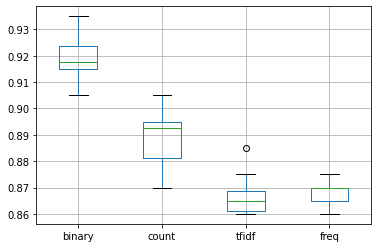

In [51]:
results.boxplot()
pyplot.show()

In [68]:
text = 'BAD'
percent, sentiment = predict_sentiment(text, vocab, tokenizer, model) 
print('Review: [%s]\nSentiment: %s (%.3f%%)' % (text, sentiment, percent*100)) # test negative text
text = 'This is a bad movie.'
percent, sentiment = predict_sentiment(text, vocab, tokenizer, model) 
print('Review: [%s]\nSentiment: %s (%.3f%%)' % (text, sentiment, percent*100))

Review: [BAD]
Sentiment: NEGATIVE (51.729%)
Review: [This is a bad movie.]
Sentiment: NEGATIVE (55.532%)
